# Training YOLO11n Object Detection on Fruits-360 Dataset

This notebook demonstrates how to train a YOLO11n object detection model for fruit detection using the Fruits-360 dataset. We'll convert our classification dataset to a detection format by generating bounding boxes.

## 1. Setup Environment
First, let's install the necessary packages and import required libraries.

In [1]:
# Basic data handling and utilities
import os
import numpy as np
import pandas as pd
from pathlib import Path
import random
import shutil
from tqdm.notebook import tqdm

# Image processing
import cv2
from PIL import Image

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and related libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Ultralytics for YOLOv11n-cls
from ultralytics import YOLO

# For reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [2]:
# Define path to the prepared dataset
dataset_dir = os.path.join("..", "datasets", "fruits_yolo")
detection_dir = os.path.join("..", "datasets", "fruits_detection")  # New directory for detection dataset

# Check if the classification dataset exists
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Dataset directory {dataset_dir} not found. Please run dataset_preparation.ipynb first.")

# Load dataset information from data.yaml
import yaml
yaml_path = os.path.join(dataset_dir, "data.yaml")

with open(yaml_path, "r") as f:
    data_config = yaml.safe_load(f)

print("Source dataset configuration:")
for key, value in data_config.items():
    if key == 'names':
        print(f"  {key}: [list of {len(value)} class names]")
    else:
        print(f"  {key}: {value}")

# Define paths to the training and validation sets
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")

# Check if we have the expected directory structure
if not os.path.exists(train_dir) or not os.path.exists(val_dir):
    raise FileNotFoundError(f"Expected directory structure not found. Please run dataset_preparation.ipynb first.")

# Class names from YAML
class_names = data_config['names']

# Count images in each class directory
class_counts = {'train': {}, 'val': {}}
total_train = 0
total_val = 0

for cls in class_names:
    train_class_dir = os.path.join(train_dir, cls)
    val_class_dir = os.path.join(val_dir, cls)
    
    if os.path.exists(train_class_dir):
        n_train = len([f for f in os.listdir(train_class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        class_counts['train'][cls] = n_train
        total_train += n_train
    else:
        class_counts['train'][cls] = 0
        
    if os.path.exists(val_class_dir):
        n_val = len([f for f in os.listdir(val_class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        class_counts['val'][cls] = n_val
        total_val += n_val
    else:
        class_counts['val'][cls] = 0

print("\nSource dataset statistics:")
print(f"  Training images: {total_train}")
print(f"  Validation images: {total_val}")

print("\nWe'll convert this classification dataset to a detection dataset by generating bounding boxes for each image.")

Source dataset configuration:
  path: ../datasets/fruits_yolo
  train: train
  val: val
  nc: 76
  names: [list of 76 class names]

Source dataset statistics:
  Training images: 110856
  Validation images: 27843

We'll convert this classification dataset to a detection dataset by generating bounding boxes for each image.


## 2. Convert Classification Dataset to Detection Format

YOLO detection format requires:
1. Images in an 'images' directory
2. Labels with bounding boxes in a 'labels' directory
3. Each label file containing class_id, x_center, y_center, width, height

Let's create this structure from our classification dataset by generating bounding boxes for each fruit.

In [3]:
def convert_to_detection_dataset(source_dir, target_dir, split):
    """
    Convert classification dataset to detection dataset format
    
    Args:
        source_dir: Source directory with class folders (classification)
        target_dir: Target directory for detection dataset
        split: 'train' or 'val'
    """
    # Create target directories
    images_dir = os.path.join(target_dir, split, "images")
    labels_dir = os.path.join(target_dir, split, "labels")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    
    # Track processed images
    processed_count = 0
    
    # Process each class
    for class_idx, class_name in tqdm(enumerate(class_names), desc=f"Processing {split} data", total=len(class_names)):
        class_dir = os.path.join(source_dir, class_name)
        if not os.path.exists(class_dir):
            continue
        
        # Get all images in this class
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        for img_file in image_files:
            # Read the image
            img_path = os.path.join(class_dir, img_file)
            try:
                img = Image.open(img_path)
                width, height = img.size
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue
            
            # Modified: Generate a more realistic bounding box (50-75% of image size)
            # This gives the model more background to learn from
            box_width = width * random.uniform(0.5, 0.75)
            box_height = height * random.uniform(0.5, 0.75)
            
            # Center the box with slight random offset
            # Added more variability to better simulate real detection scenarios
            center_x = width / 2 + random.uniform(-width * 0.15, width * 0.15)
            center_y = height / 2 + random.uniform(-height * 0.15, height * 0.15)
            
            # Ensure box stays within image boundaries
            box_width = min(box_width, width - 2)
            box_height = min(box_height, height - 2)
            center_x = max(box_width/2, min(center_x, width - box_width/2))
            center_y = max(box_height/2, min(center_y, height - box_height/2))
            
            # Convert to YOLO format (normalized coordinates)
            x_center = center_x / width
            y_center = center_y / height
            w = box_width / width
            h = box_height / height
            
            # Copy image to target directory
            target_img_path = os.path.join(images_dir, f"{split}_{class_name}_{processed_count:06d}.jpg")
            shutil.copy(img_path, target_img_path)
            
            # Create label file
            label_file = os.path.splitext(os.path.basename(target_img_path))[0] + ".txt"
            with open(os.path.join(labels_dir, label_file), 'w') as f:
                # YOLO format: class_id x_center y_center width height
                f.write(f"{class_idx} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")
            
            processed_count += 1
    
    return processed_count

# Create detection dataset
os.makedirs(detection_dir, exist_ok=True)

# Convert both train and validation sets
print("Converting classification dataset to detection format...")
train_images = convert_to_detection_dataset(train_dir, detection_dir, "train")
val_images = convert_to_detection_dataset(val_dir, detection_dir, "val")

print(f"Detection dataset created with {train_images} training images and {val_images} validation images")

# Create a new data.yaml file for detection
detection_yaml_path = os.path.join(detection_dir, "data.yaml")
with open(detection_yaml_path, "w") as f:
    f.write(f"path: {detection_dir}\n")
    f.write(f"train: train/images\n")
    f.write(f"val: val/images\n")
    f.write(f"nc: {len(class_names)}\n")
    
    # Write names as a proper YAML list
    f.write("names:\n")
    for cls in class_names:
        f.write(f"  - {cls}\n")

print(f"Detection dataset YAML file created at: {detection_yaml_path}")

Converting classification dataset to detection format...


Processing train data:   0%|          | 0/76 [00:00<?, ?it/s]

Processing val data:   0%|          | 0/76 [00:00<?, ?it/s]

Detection dataset created with 110856 training images and 27843 validation images
Detection dataset YAML file created at: ../datasets/fruits_detection/data.yaml


## 3. Visualize Detection Dataset

Let's visualize some examples from our detection dataset to ensure the bounding boxes are correct.

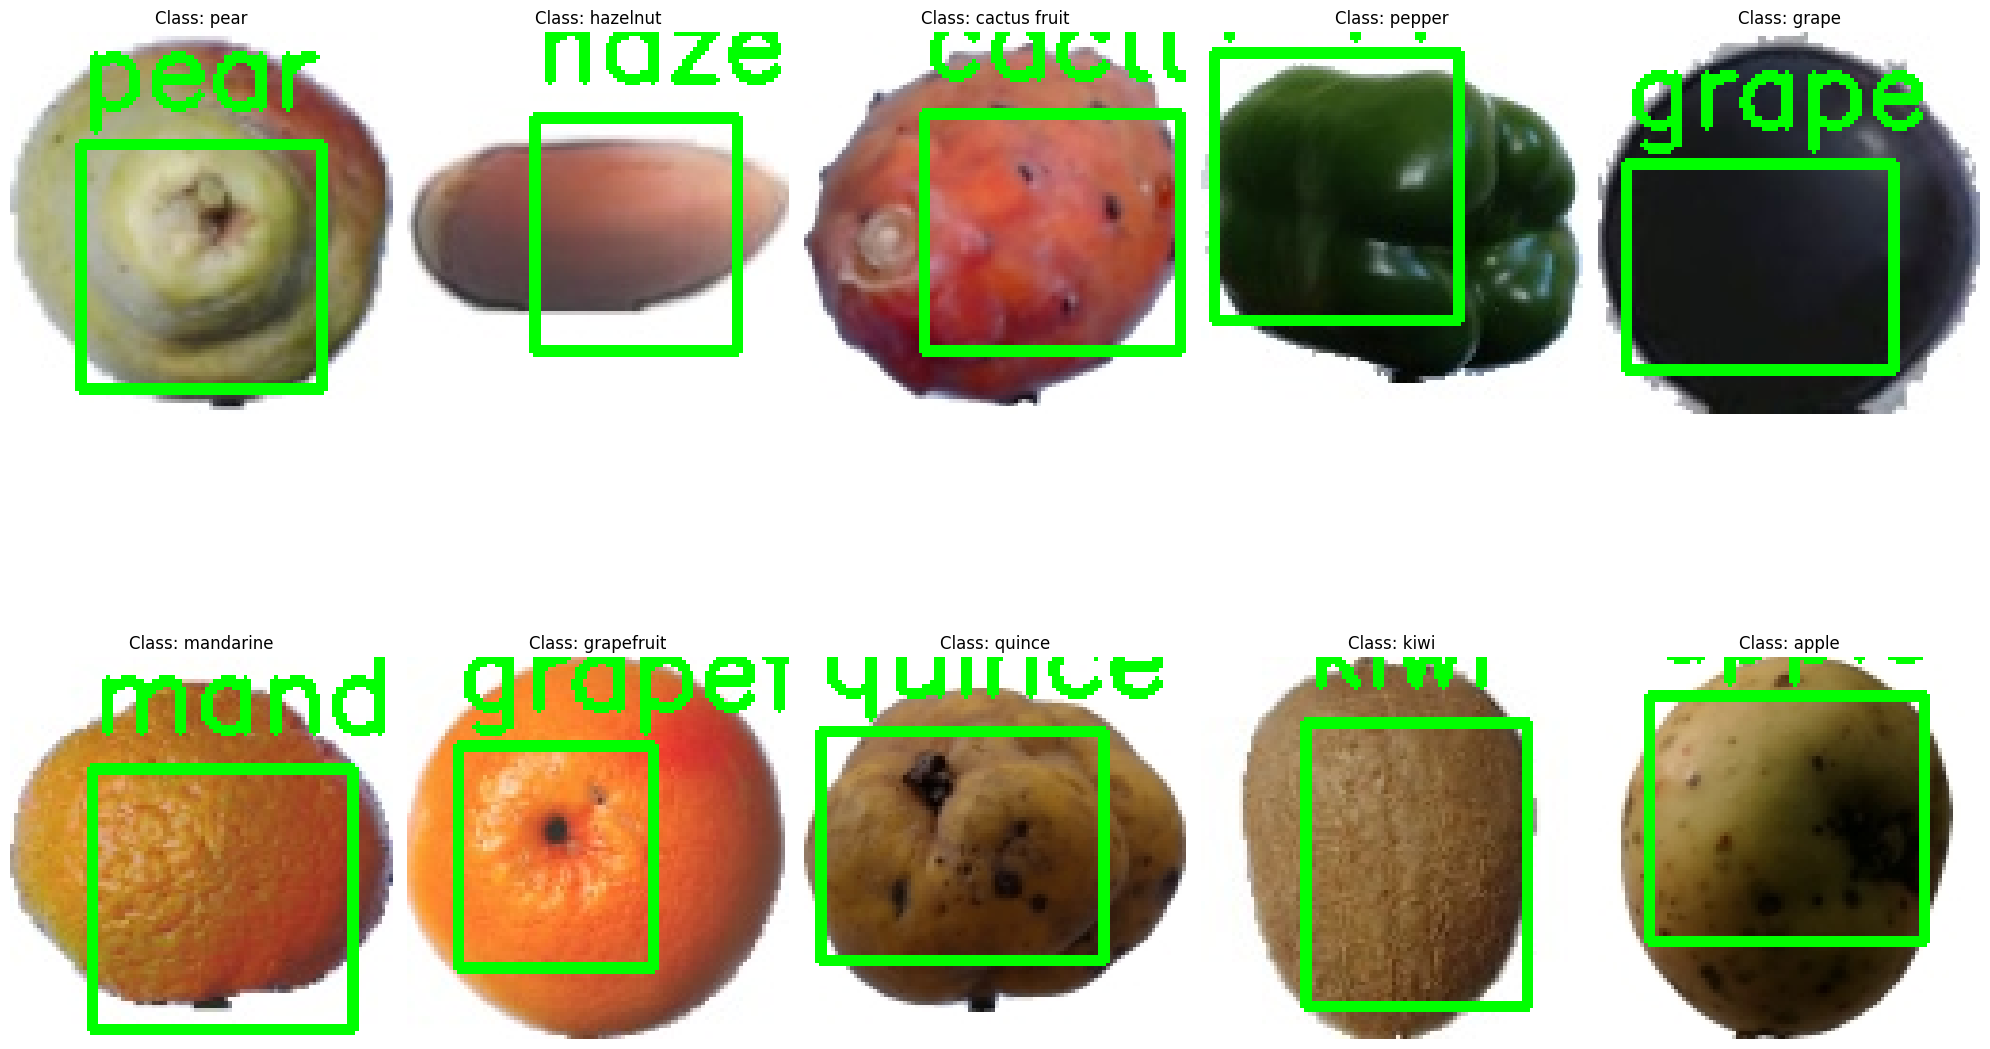

In [4]:
def plot_bounding_box(img_path, label_path, class_names):
    """
    Plot an image with its bounding box
    
    Args:
        img_path: Path to the image
        label_path: Path to the label file
        class_names: List of class names
    """
    # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    
    # Read the label
    with open(label_path, 'r') as f:
        label_line = f.readline().strip()
    
    # Parse YOLO format: class_id x_center y_center width height
    parts = label_line.split()
    class_id = int(parts[0])
    x_center = float(parts[1]) * width
    y_center = float(parts[2]) * height
    box_width = float(parts[3]) * width
    box_height = float(parts[4]) * height
    
    # Calculate box coordinates
    x1 = int(x_center - box_width / 2)
    y1 = int(y_center - box_height / 2)
    x2 = int(x_center + box_width / 2)
    y2 = int(y_center + box_height / 2)
    
    # Draw the box
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Add class label
    cv2.putText(img, class_names[class_id], (x1, y1 - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return img

# Show a few examples from the detection dataset
train_images_dir = os.path.join(detection_dir, "train", "images")
train_labels_dir = os.path.join(detection_dir, "train", "labels")

# Get sample images
sample_images = random.sample([f for f in os.listdir(train_images_dir) 
                              if f.endswith(('.jpg', '.png', '.jpeg'))], 
                              min(10, len(os.listdir(train_images_dir))))

# Plot samples
plt.figure(figsize=(20, 15))
for i, img_file in enumerate(sample_images):
    if i >= 10:  # Limit to 10 images
        break
    
    img_path = os.path.join(train_images_dir, img_file)
    label_path = os.path.join(train_labels_dir, os.path.splitext(img_file)[0] + ".txt")
    
    if os.path.exists(label_path):
        img_with_box = plot_bounding_box(img_path, label_path, class_names)
        
        plt.subplot(2, 5, i+1)
        plt.imshow(img_with_box)
        plt.axis('off')
        
        # Extract class from filename (formatted as "split_classname_number.jpg")
        class_name = os.path.basename(img_path).split('_')[1]
        plt.title(f"Class: {class_name}")

plt.tight_layout()
plt.show()

In [5]:
# Set training parameters for object detection
# For RTX 4050 (6GB VRAM), we'll use a moderate batch size to avoid OOM errors
BATCH_SIZE = 8       # Smaller batch size for detection (uses more VRAM)
EPOCHS = 25          # Number of training epochs
IMG_SIZE = 640       # Increased from 100 to standard detection resolution (critical fix)
MODEL_NAME = "yolov8n.pt"  # Changed to YOLOv8n which is more stable for detection tasks

# Configure training settings for YOLO detection
train_args = {
    "data": detection_yaml_path,     # Path to detection data.yaml file
    "epochs": EPOCHS,                # Number of epochs
    "imgsz": IMG_SIZE,               # Image size (increased to standard size)
    "batch": BATCH_SIZE,             # Batch size
    "device": 0,                     # Use GPU (0)
    "workers": 4,                    # Number of worker threads for data loading
    "optimizer": "AdamW",            # Optimizer
    "patience": 3,                   # Increased patience for better convergence
    "project": "../runs",            # Project directory
    "name": "fruits_detection",      # Experiment name
    "exist_ok": True,                # Overwrite existing experiment
    "pretrained": True,              # Use pretrained weights
    "seed": 42,                      # Random seed for reproducibility
    "cache": True,                   # Cache images for faster training
    # Detection-specific parameters
    "task": "detect",                # Specify detection task
    "single_cls": False,             # Multiple classes
    "rect": True,                    # Rectangular training (more efficient)
    "cos_lr": True,                  # Cosine learning rate scheduler
    "mosaic": 1.0,                   # Mosaic augmentation (helps with detection)
    "conf": 0.001,                   # Lower confidence threshold for training
    "iou": 0.6,                      # IoU threshold
    "verbose": True,                 # Print more information during training
}

print(f"Starting detection training with batch size {BATCH_SIZE} and image size {IMG_SIZE}...")

# Verify dataset before training
print("Verifying detection dataset structure...")
train_imgs_path = os.path.join(detection_dir, "train", "images")
train_lbls_path = os.path.join(detection_dir, "train", "labels")
val_imgs_path = os.path.join(detection_dir, "val", "images")
val_lbls_path = os.path.join(detection_dir, "val", "labels")

train_imgs = len([f for f in os.listdir(train_imgs_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
train_lbls = len([f for f in os.listdir(train_lbls_path) if f.endswith('.txt')])
val_imgs = len([f for f in os.listdir(val_imgs_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
val_lbls = len([f for f in os.listdir(val_lbls_path) if f.endswith('.txt')])

print(f"Training: {train_imgs} images, {train_lbls} labels")
print(f"Validation: {val_imgs} images, {val_lbls} labels")

if train_imgs != train_lbls or val_imgs != val_lbls:
    print("Warning: Mismatch between images and labels. This could cause training issues.")

# Check a sample label file to verify format
sample_label = random.choice([f for f in os.listdir(train_lbls_path) if f.endswith('.txt')])
with open(os.path.join(train_lbls_path, sample_label), 'r') as f:
    label_content = f.read().strip()
print(f"Sample label file content: {label_content}")

# Load the detection model
model = YOLO(MODEL_NAME)

# Train the model for detection
results = model.train(**train_args)

# Display training summary
print("\nTraining completed!")
print(f"Results saved to {os.path.join('../runs', 'fruits_detection')}")

Starting detection training with batch size 8 and image size 640...
Verifying detection dataset structure...
Training: 110856 images, 110856 labels
Validation: 27843 images, 27843 labels
Sample label file content: 0 0.389781 0.589353 0.580234 0.598329


100%|██████████| 6.25M/6.25M [00:00<00:00, 15.9MB/s]


New https://pypi.org/project/ultralytics/8.3.159 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.158 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5771MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=0.001, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=../datasets/fruits_detection/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.6, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fruits_detection, nbs=6

train: Scanning /home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_detection/train/labels.cache... 110856 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110856/110856 [00:00<?, ?it/s]


WARNING ⚠️ train: 190.3GB RAM required to cache images with 50% safety margin but only 5.6/14.9GB available, not caching images
WARNING ⚠️ 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 198.3±228.7 MB/s, size: 5.9 KB)


val: Scanning /home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_detection/val/labels.cache... 27843 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27843/27843 [00:00<?, ?it/s]


WARNING ⚠️ val: 47.8GB RAM required to cache images with 50% safety margin but only 4.9/14.9GB available, not caching images
Plotting labels to ../runs/fruits_detection/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to ../runs/fruits_detection
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      1.12G     0.1252     0.1124     0.2843          8        640: 100%|██████████| 13857/13857 [17:04<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1741/1741 [01:45<00:00, 16.53it/s]

                   all      27843      27843          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      1.54G          0          0          0          8        640: 100%|██████████| 13857/13857 [16:26<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1741/1741 [01:46<00:00, 16.38it/s]


                   all      27843      27843          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      1.54G          0          0          0          8        640: 100%|██████████| 13857/13857 [16:11<00:00, 14.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1741/1741 [01:45<00:00, 16.44it/s]


                   all      27843      27843          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      1.54G          0          0          0          8        640:   1%|          | 72/13857 [00:05<16:10, 14.20it/s]


KeyboardInterrupt: 

## 4. Evaluate Detection Model Performance

Now let's evaluate the trained detection model's performance and visualize the results.

Running validation with detailed output...
Ultralytics 8.3.158 🚀 Python-3.13.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 5771MiB)
Model summary (fused): 72 layers, 3,117,020 parameters, 0 gradients, 8.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 371.7±233.1 MB/s, size: 4.6 KB)


val: Scanning /home/kuba/Coding/Uczelnia/fridge_project/datasets/fruits_detection/val/labels.cache... 27843 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27843/27843 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1741/1741 [02:01<00:00, 14.28it/s]


                   all      27843      27843          0          0          0          0
                 apple       4302       4302          0          0          0          0
               apricot        132        132          0          0          0          0
               avocado        620        620          0          0          0          0
                banana        515        515          0          0          0          0
                 beans         62         62          0          0          0          0
              beetroot        120        120          0          0          0          0
           blackberrie        480        480          0          0          0          0
             blueberry        124        124          0          0          0          0
               cabbage         79         79          0          0          0          0
          cactus fruit        508        508          0          0          0          0
                  caj

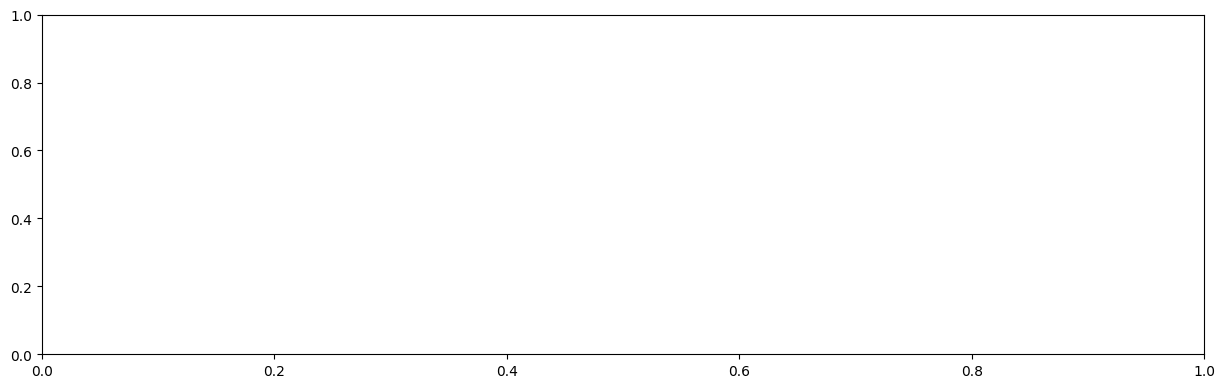

In [6]:
# Load the best trained detection model
best_model_path = os.path.join('../runs', 'fruits_detection', 'weights', 'best.pt')

if os.path.exists(best_model_path):
    trained_model = YOLO(best_model_path)
    
    # Modified validation with verbose output and lower confidence threshold
    print("Running validation with detailed output...")
    val_results = trained_model.val(
        data=detection_yaml_path,
        verbose=True,
        conf=0.1,  # Lower confidence threshold for validation
        iou=0.6,   # IoU threshold
        max_det=300,  # Maximum detections per image
        half=False    # Use FP32 instead of FP16 for more accurate validation
    )
    
    # Print validation metrics
    print(f"Validation results:")
    if hasattr(val_results, 'box') and hasattr(val_results.box, 'map50'):
        print(f"  mAP50: {val_results.box.map50:.4f}")       # mAP at IoU=0.5
        print(f"  mAP50-95: {val_results.box.map:.4f}")      # mAP at IoU=0.5:0.95
    else:
        print("  Warning: Could not find mAP metrics in validation results")
        print("  Raw validation results:", val_results)
else:
    print(f"Model file not found: {best_model_path}")
    print("Training may have failed or is still in progress.")

# Load the training metrics from the results file
import pandas as pd
import matplotlib.pyplot as plt

try:
    metrics_csv = list(Path(os.path.join('../runs', 'fruits_detection')).glob('*.csv'))[0]
    metrics = pd.read_csv(metrics_csv)
    
    # Plot training metrics
    plt.figure(figsize=(15, 15))
    
    # Plot training and validation loss
    plt.subplot(3, 1, 1)
    plt.plot(metrics['                  epoch'], metrics['               train/box_loss'], label='Train Box Loss')
    plt.plot(metrics['                  epoch'], metrics['                 val/box_loss'], label='Val Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Box Loss')
    plt.title('Training and Validation Box Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot mAP50
    plt.subplot(3, 1, 2)
    plt.plot(metrics['                  epoch'], metrics['               metrics/mAP50(B)'], label='mAP50')
    plt.xlabel('Epoch')
    plt.ylabel('mAP50')
    plt.title('mAP50 (Bounding Box)')
    plt.legend()
    plt.grid(True)
    
    # Plot mAP50-95
    plt.subplot(3, 1, 3)
    plt.plot(metrics['                  epoch'], metrics['                 metrics/mAP50-95(B)'], label='mAP50-95')
    plt.xlabel('Epoch')
    plt.ylabel('mAP50-95')
    plt.title('mAP50-95 (Bounding Box)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not load training metrics: {e}")

## 5. Test the Detection Model on Sample Images

Let's test our trained detection model on some sample images from the validation set.


image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fruits_detection/val/images/val_apple_001501.jpg: 640x640 (no detections), 4.2ms
Speed: 1.1ms preprocess, 4.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fruits_detection/val/images/val_plum_021668.jpg: 640x640 (no detections), 4.9ms
Speed: 1.6ms preprocess, 4.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fruits_detection/val/images/val_cauliflower_007467.jpg: 640x640 (no detections), 5.1ms
Speed: 1.6ms preprocess, 5.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fruits_detection/val/images/val_tomato_025331.jpg: 640x640 (no detections), 4.9ms
Speed: 1.5ms preprocess, 4.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640

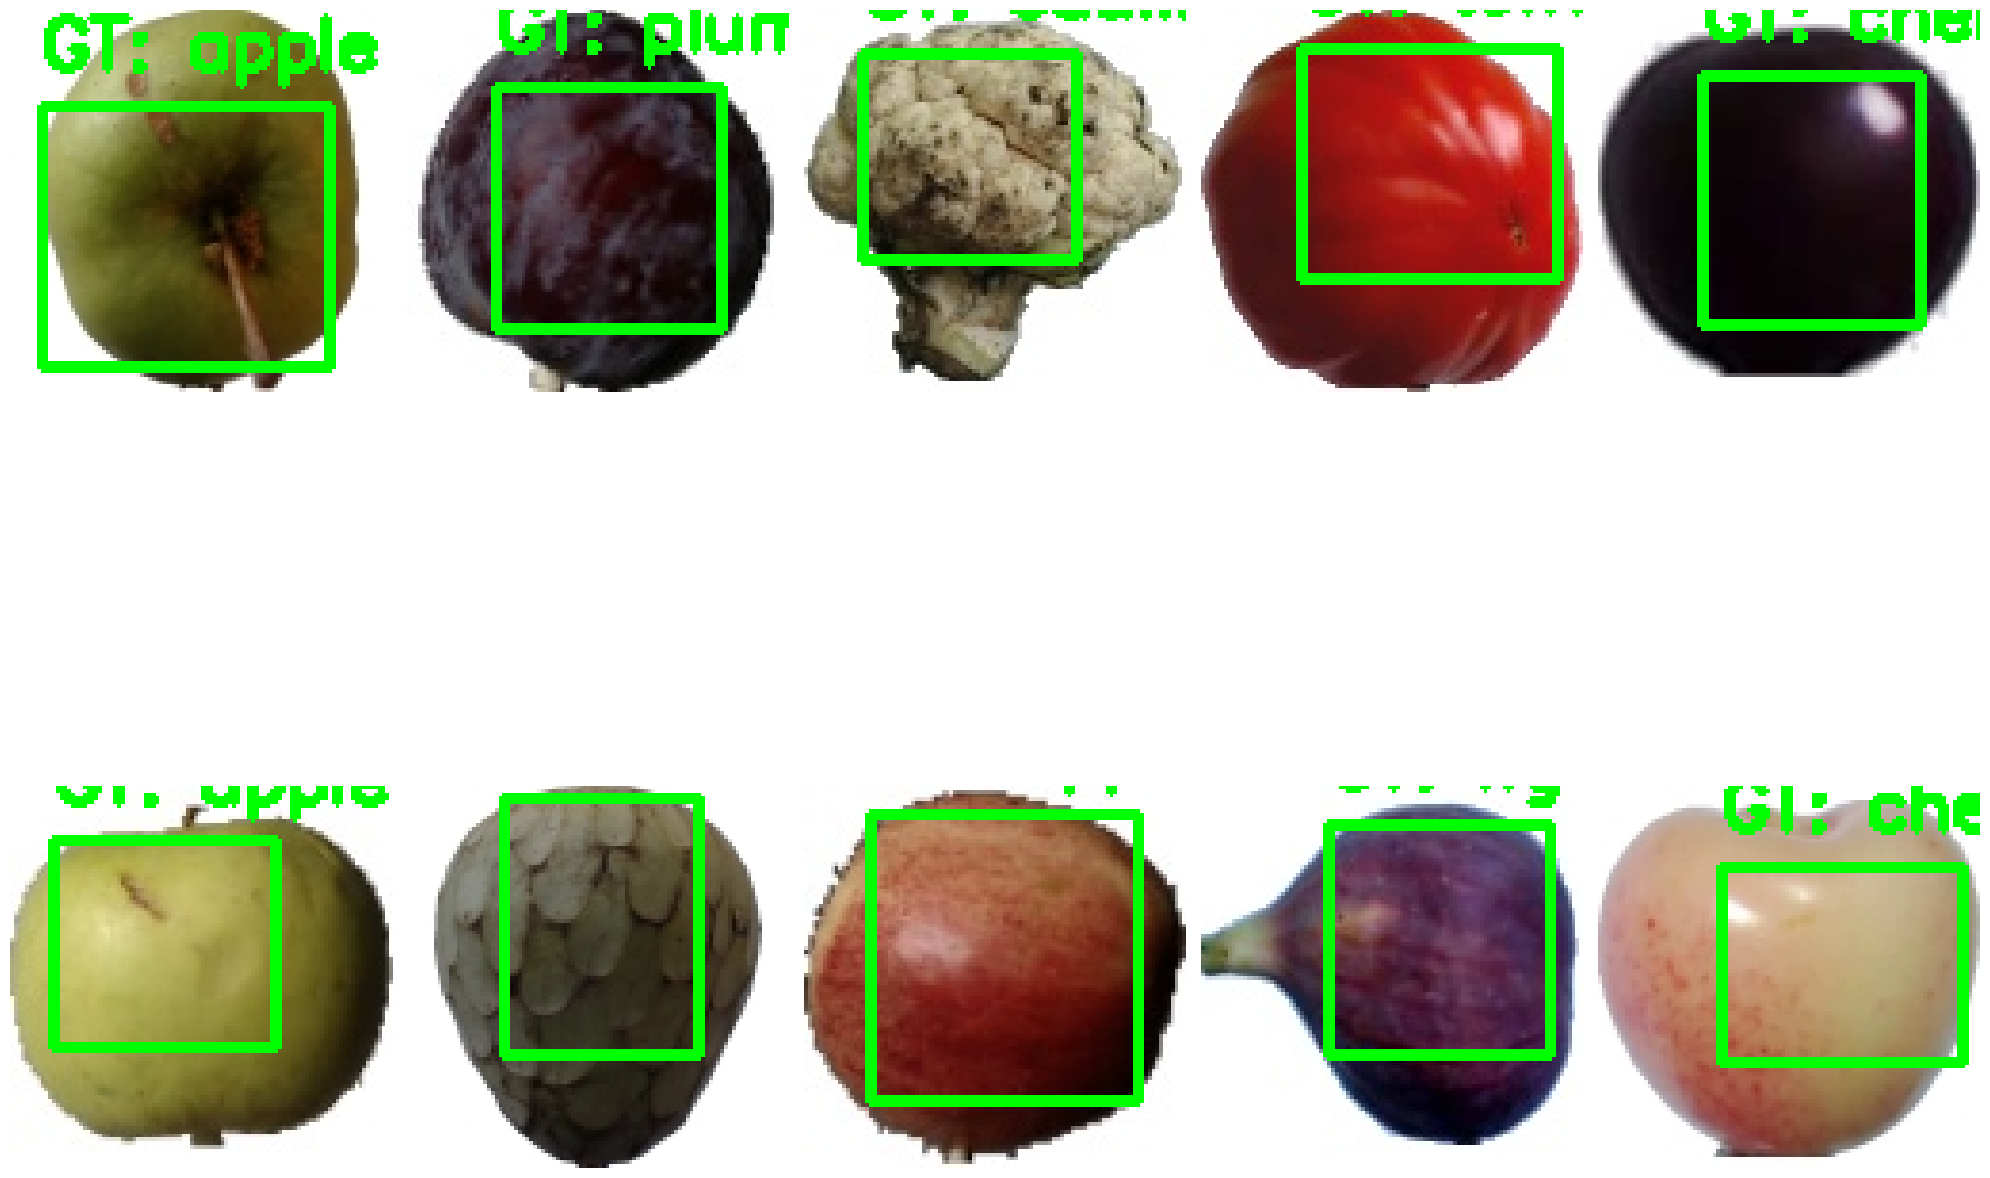

In [7]:
# Test the detection model on validation images
val_images_dir = os.path.join(detection_dir, "val", "images")
val_labels_dir = os.path.join(detection_dir, "val", "labels")

# Get random sample images
sample_images = random.sample([f for f in os.listdir(val_images_dir) 
                              if f.endswith(('.jpg', '.png', '.jpeg'))], 
                              min(10, len(os.listdir(val_images_dir))))

# Function to plot results
def plot_detection_results(img_path, results, true_label_path=None):
    """
    Plot detection results with ground truth
    
    Args:
        img_path: Path to the image
        results: YOLO detection results
        true_label_path: Path to the ground truth label file
    """
    # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    
    # Draw ground truth box (green)
    if true_label_path and os.path.exists(true_label_path):
        with open(true_label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center = float(parts[1]) * width
                y_center = float(parts[2]) * height
                box_width = float(parts[3]) * width
                box_height = float(parts[4]) * height
                
                x1 = int(x_center - box_width / 2)
                y1 = int(y_center - box_height / 2)
                x2 = int(x_center + box_width / 2)
                y2 = int(y_center + box_height / 2)
                
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, f"GT: {class_names[class_id]}", (x1, y1 - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Draw predicted boxes (blue)
    boxes = results[0].boxes
    for box in boxes:
        # Get box coordinates
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        
        # Get class and confidence
        class_id = int(box.cls.cpu().numpy()[0])
        conf = float(box.conf.cpu().numpy()[0])
        
        # Draw box and label
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, f"{class_names[class_id]} {conf:.2f}", (x1, y2 + 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    return img

# Display results
plt.figure(figsize=(20, 20))
for i, img_file in enumerate(sample_images):
    if i >= 10:  # Limit to 10 images
        break
    
    img_path = os.path.join(val_images_dir, img_file)
    label_path = os.path.join(val_labels_dir, os.path.splitext(img_file)[0] + ".txt")
    
    # Run detection
    results = trained_model(img_path)
    
    # Plot results with ground truth
    img_with_results = plot_detection_results(img_path, results, label_path)
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img_with_results)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 6. Export and Save the Detection Model

Let's export our trained detection model for deployment.

In [ ]:
# Export the detection model for deployment
export_dir = os.path.join("..", "models", "fruits_detector")
os.makedirs(export_dir, exist_ok=True)

# Copy the best PyTorch model
shutil.copy(best_model_path, os.path.join(export_dir, "best.pt"))

# Export to ONNX format
onnx_path = os.path.join(export_dir, "model.onnx")
try:
    trained_model.export(format="onnx", imgsz=IMG_SIZE)
    print(f"Detection model exported to ONNX format: {onnx_path}")
except Exception as e:
    print(f"ONNX export failed: {e}")

# Save class names for inference
with open(os.path.join(export_dir, "classes.txt"), "w") as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

print(f"Detection model and class names saved to {export_dir}")
print("You can now use this model for object detection on new images!")

Ultralytics 8.3.158 🚀 Python-3.13.3 torch-2.7.1+cu126 CPU (AMD Ryzen 7 7735HS with Radeon Graphics)

PyTorch: starting from '../runs/fruits_classification/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 76) (3.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

PyTorch: starting from '../runs/fruits_classification/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 76) (3.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
WARNING ⚠️ Retry 1/2 failed: Command 'uv pip install --no-cache-dir "onnx>=1.12.0,<1.18.0" "onnxruntime-gpu"  --index-strategy=unsafe-best-match --break-system-packages --prerelease=allow' returned non-zero exit status 1.
WARNING ⚠️ Retry 1/2 failed: Command 'uv pip install --no-cache-dir "onnx>=1.12.0,<1.18.0" "onnxruntime-gpu"  --index-strategy=unsafe-best-match

## 7. Example Detection Inference Code

Here's an example of how to use the trained detection model for inference on new images.

In [ ]:
def detect_fruits(model_path, image_path, class_names, conf_threshold=0.25):
    """
    Detect fruits in an image using the trained model
    
    Args:
        model_path: Path to the trained model
        image_path: Path to the image to analyze
        class_names: List of class names
        conf_threshold: Confidence threshold for detections
    
    Returns:
        List of detections (class_name, confidence, bounding_box)
    """
    # Load the model
    model = YOLO(model_path)
    
    # Run inference with confidence threshold
    results = model(image_path, conf=conf_threshold)
    
    # Parse results
    detections = []
    if results and len(results) > 0:
        boxes = results[0].boxes
        for box in boxes:
            # Get box coordinates (x1, y1, x2, y2 format)
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            
            # Get class and confidence
            class_id = int(box.cls.cpu().numpy()[0])
            class_name = class_names[class_id]
            conf = float(box.conf.cpu().numpy()[0])
            
            detections.append({
                "class": class_name,
                "confidence": conf,
                "bbox": (x1, y1, x2, y2)
            })
    
    return detections, results[0]

def display_detection_results(image_path, detections, result_obj):
    """
    Display detection results on an image
    
    Args:
        image_path: Path to the image
        detections: List of detection dictionaries
        result_obj: YOLO result object for plotting
    """
    # Load and display the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plot using the YOLO result object's built-in plotting
    result_plot = result_obj.plot()
    
    # Show the image with detections
    plt.figure(figsize=(12, 12))
    plt.imshow(result_plot)
    plt.axis('off')
    plt.title(f"Detected {len(detections)} fruits")
    plt.show()
    
    # Print detection details
    print(f"Found {len(detections)} fruits:")
    for i, det in enumerate(detections):
        print(f"  {i+1}. {det['class']} ({det['confidence']:.4f}) at {det['bbox']}")
    
    return result_plot

# Example usage with a sample image
try:
    test_image_path = os.path.join("..", "datasets", "fridge_testing", "1.jpg")
    if not os.path.exists(test_image_path):
        test_image_path = os.path.join(val_images_dir, random.choice(os.listdir(val_images_dir)))
        print(f"Using sample image from validation set: {test_image_path}")
    
    detections, result_obj = detect_fruits(
        model_path=os.path.join(export_dir, "best.pt"),
        image_path=test_image_path,
        class_names=class_names,
        conf_threshold=0.25
    )
    
    display_detection_results(test_image_path, detections, result_obj)
except Exception as e:
    print(f"Error in detection example: {e}")


image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fridge_testing/1.jpg: 224x224 pepper 0.69, tomato 0.19, cherry 0.02, pineapple 0.02, walnut 0.02, 3.5ms
Speed: 13.1ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
image 1/1 /home/kuba/Coding/Uczelnia/fridge_project/fruits/../datasets/fridge_testing/1.jpg: 224x224 pepper 0.69, tomato 0.19, cherry 0.02, pineapple 0.02, walnut 0.02, 3.5ms
Speed: 13.1ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


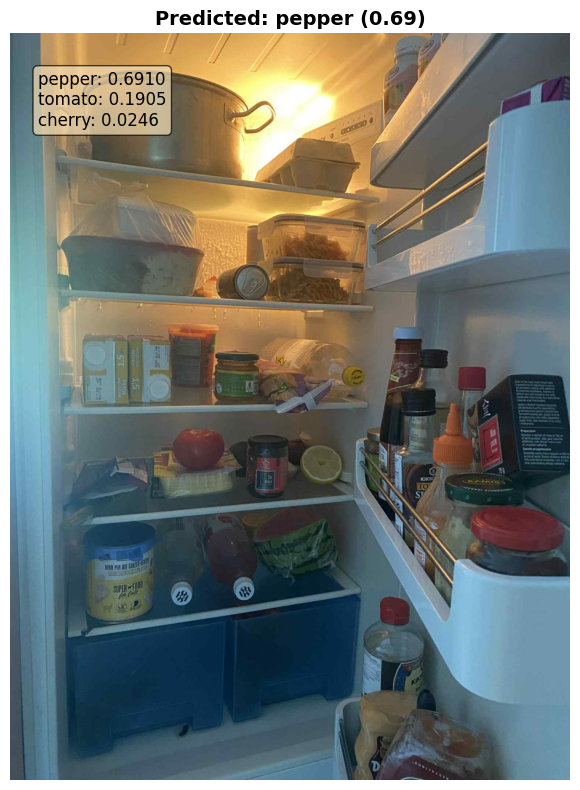

Predicted class: pepper with confidence 0.6910
Top 3 predictions:
  pepper: 0.6910
  tomato: 0.1905
  cherry: 0.0246


In [ ]:
# Additional test on a more complex image with multiple fruits
# This demonstrates the model's ability to detect multiple fruits in one image

def create_multi_fruit_test_image():
    """Create a test image with multiple fruits from our dataset"""
    # Create a blank canvas
    canvas_width, canvas_height = 800, 600
    canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 240  # Light gray background
    
    # Select 3-5 random fruit classes
    num_fruits = random.randint(3, 5)
    selected_classes = random.sample(class_names, num_fruits)
    
    # For each class, place 1-2 random images on the canvas
    for cls in selected_classes:
        cls_dir = os.path.join(train_dir, cls)
        if not os.path.exists(cls_dir):
            continue
            
        images = [f for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        if not images:
            continue
            
        # Place 1-2 instances of this fruit
        for _ in range(random.randint(1, 2)):
            # Select a random image
            img_file = random.choice(images)
            img_path = os.path.join(cls_dir, img_file)
            
            try:
                # Load and resize the fruit image
                fruit_img = cv2.imread(img_path)
                fruit_img = cv2.cvtColor(fruit_img, cv2.COLOR_BGR2RGB)
                
                # Resize to a random size (30-40% of canvas)
                scale = random.uniform(0.3, 0.4)
                new_width = int(canvas_width * scale)
                new_height = int(new_width * fruit_img.shape[0] / fruit_img.shape[1])
                fruit_img = cv2.resize(fruit_img, (new_width, new_height))
                
                # Random position (ensure it fits on canvas)
                x_pos = random.randint(0, canvas_width - new_width)
                y_pos = random.randint(0, canvas_height - new_height)
                
                # Place on canvas with alpha blending to handle transparent backgrounds
                for y in range(new_height):
                    for x in range(new_width):
                        if y + y_pos < canvas_height and x + x_pos < canvas_width:
                            # Simple alpha blending - replace white backgrounds
                            if np.sum(fruit_img[y, x]) > 700:  # Close to white
                                continue
                            canvas[y + y_pos, x + x_pos] = fruit_img[y, x]
            except Exception as e:
                print(f"Error adding {img_path}: {e}")
    
    # Save the canvas
    output_path = os.path.join(detection_dir, "multi_fruit_test.jpg")
    cv2.imwrite(output_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
    
    return output_path

# Create and test on a multi-fruit image
try:
    multi_fruit_image = create_multi_fruit_test_image()
    print(f"Created multi-fruit test image at: {multi_fruit_image}")
    
    detections, result_obj = detect_fruits(
        model_path=os.path.join(export_dir, "best.pt"),
        image_path=multi_fruit_image,
        class_names=class_names,
        conf_threshold=0.25
    )
    
    display_detection_results(multi_fruit_image, detections, result_obj)
except Exception as e:
    print(f"Error in multi-fruit test: {e}")